In [17]:
%matplotlib inline
import numpy as np
import pandas as pd
from decision_tree import DecisionTree
from graphviz import Digraph
from dataset import Dataset
import matplotlib.pyplot as plt
import seaborn as sn

In [18]:
TRAIN_DATA_PATH = "data/ann-train.data"
TEST_DATA_PATH = "data/ann-test.data"
COST_DATA_PATH = "data/ann-thyroid.cost"

dataset = Dataset(TRAIN_DATA_PATH, TEST_DATA_PATH, COST_DATA_PATH)
train_sample_count = dataset.train_data.to_numpy().shape[0]
test_sample_count = dataset.test_data.to_numpy().shape[0]
print("Dataset Loaded: There are {} training samples and {} test samples in the dataset".format(train_sample_count, test_sample_count))

Dataset Loaded: There are 3772 training samples and 3428 test samples in the dataset


In [19]:
# Converting data samples to usable format 
train_data = dataset.train_data.to_numpy()
test_data = dataset.test_data.to_numpy()
print("Shape of training data: {}".format(train_data.shape))
print("Shape of test data: {}".format(test_data.shape))

Shape of training data: (3772, 22)
Shape of test data: (3428, 22)


In [20]:
def plot_matrix(confusion_matrix):
    matrix_df = pd.DataFrame(confusion_matrix, index=["1", "2", "3"], columns=["1", "2", "3"])
    matrix_df.index.name = "True Label"
    matrix_df.columns.name = "Predicted Label"
    plt.figure(figsize = (8,5))
    sn.set(font_scale=1.4)
    sn.heatmap(matrix_df,annot=True, fmt="d", linewidths=.5, annot_kws={"size": 18}, cmap="Blues")

In [21]:
def evaluate_matrix(matrix):
    assert matrix.shape[0] == matrix.shape[1]
    no_of_classes = matrix.shape[0]
    overall_acc = sum([matrix[i, i] for i in range(matrix.shape[0])]) / np.sum(matrix)
    accuracies = []
    for class_no in range(matrix.shape[0]):
        if np.sum(matrix[class_no, :]) == 0:
            acc = 0
        else:
            acc = matrix[class_no, class_no] / np.sum(matrix[class_no, :])
        accuracies.append(acc)
    return overall_acc, accuracies

In [22]:
class TreePlot():
    def __init__(self):
        self.last_node = 0
        self.graph = None

def get_node_text(node):
    node_text = ""
    if node.left_child == None or node.right_child == None: # Leaf Node
        node_text += "Score: {}\n".format(node.score)
        node_text += "Samples: {}\n".format(np.sum(node.class_dist))
        node_text += "Class Dist: {}\n".format(node.class_dist)
        node_text += "Label: {}".format(node.label)
    else:
        node_text += "Split rule: {} <= {}\n".format(classifier.features[node.feature_idx], node.threshold)
        node_text += "Score: {}\n".format(node.score)
        node_text += "Samples: {}\n".format(np.sum(node.class_dist))
        node_text += "Class Dist: {}\n".format(node.class_dist)
    return node_text
        

def plot_tree(classifier):
    plot = TreePlot()
    plot.graph = Digraph(name="part3", format="png", filename="part2.gv")
    classifier.root.score = round(classifier.root.score, 5)
    classifier.root.threshold = round(classifier.root.threshold, 5)
    node_text = get_node_text(classifier.root)
    plot.last_node += 1
    plot.graph.attr("node", shape="box")
    plot.graph.node("node_" + str(plot.last_node), label=node_text, style="filled", fillcolor="green", fontsize="8")
    node_no = plot.last_node
    traverse_tree(plot, classifier.root.left_child, node_no)
    traverse_tree(plot, classifier.root.right_child, node_no)
    return plot.graph

def traverse_tree(plot, node, parent_no):
    if (node.left_child == None) or (node.right_child == None): # Leaf Node
        if node.score == -0.0:
            node.score = 0.0
        else:
            node.score = round(node.score, 5)
        node_text = get_node_text(node)
        plot.last_node += 1
        plot.graph.attr("node", shape="box", fillcolor="blue")
        plot.graph.node("node_" + str(plot.last_node), label=node_text, style="filled", fillcolor="orange",fontsize="8")
        plot.graph.edge("node_" + str(parent_no), "node_" + str(plot.last_node))
        return
    node.threshold = round(node.threshold, 5)
    node.score = round(node.score, 5)
    node_text = get_node_text(node)
    plot.last_node += 1
    plot.graph.attr("node", shape="box")
    plot.graph.node("node_" + str(plot.last_node), label=node_text, style="filled",fillcolor="green", fontsize="8")
    plot.graph.edge("node_" + str(parent_no), "node_" + str(plot.last_node))
    node_no = plot.last_node
    traverse_tree(plot, node.left_child, node_no)
    traverse_tree(plot, node.right_child, node_no)

### Cost Metrics
In order to observe the feature costs, first the given cost values with the dataset are illustrated

In [41]:
dataset.cost_data

{'age': 1.0,
 'sex': 1.0,
 'on_thyroxine': 1.0,
 'query_on_thyroxine': 1.0,
 'on_antithyroid_medication': 1.0,
 'sick': 1.0,
 'pregnant': 1.0,
 'thyroid_surgery': 1.0,
 'I131_treatment': 1.0,
 'query_hypothyroid': 1.0,
 'query_hyperthyroid': 1.0,
 'lithium': 1.0,
 'goitre': 1.0,
 'tumor': 1.0,
 'hypopituitary': 1.0,
 'psych': 1.0,
 'TSH': 22.78,
 'T3': 11.41,
 'TT4': 14.51,
 'T4U': 11.41}

## Grid Search
Just like the previous parts of the assignment, the grid search approach is used to find the absolute hyper parameters. The following function performs the grid search to report the optimal hyper parameters considering the cost

In [51]:
def find_best_params():
    possible_measures = ("entropy", "gini")
    possible_prunes = list(range(3, 12))
    possible_prunes.append(None)
    cost_enable = [True, False]
    cost_metrics = ["nunez", "tan"]
    cost_weights = [0.01, 0.05 ,0.1, 0.2, 0.5, 0.75, 1, 2]
    classes, counts = np.unique(test_data[:,-1], return_counts=True)
    weights = np.array([counts[1] * counts[2], counts[0] * counts[2], counts[1] * counts[0]])
    weights = weights / np.sum(weights)
    best_acc = 0
    best_measure = None
    best_prune = None
    best_cost_enabled = None
    best_cost = None
    best_cost_weight = None
    for measure in possible_measures:
        for prune in possible_prunes:
            for cost_enabled in cost_enable:
                if cost_enabled:
                    for cost_metric in cost_metrics:
                        if cost_metric == "nunez":
                            for weight in cost_weights:
                                classifier = DecisionTree(train_data, test_data, dataset.cost_data, impurity_measure=measure, prune_length=prune, use_cost=cost_enabled, cost_weight=weight, cost_measure=cost_metric)
                                matrix = classifier.evaluate_model()
                                acc_values = evaluate_matrix(matrix)[1]
                                acc = np.sum(weights * acc_values)
                                if acc > best_acc:
                                    best_acc = acc
                                    best_measure = measure
                                    best_prune = prune
                                    best_cost_enabled = cost_enabled
                                    best_cost = cost_metric
                                    best_cost_weight = weight
                        else:
                            classifier = DecisionTree(train_data, test_data, dataset.cost_data, impurity_measure=measure, prune_length=prune, use_cost=cost_enabled, cost_measure=cost_metric)
                            matrix = classifier.evaluate_model()
                            acc_values = evaluate_matrix(matrix)[1]
                            acc = np.sum(weights * acc_values)
                            if acc > best_acc:
                                best_acc = acc
                                best_measure = measure
                                best_prune = prune
                                best_cost_enabled = cost_enabled
                                best_cost = cost_metric
                                best_cost_weight = None
                else:
                    classifier = DecisionTree(train_data, test_data, dataset.cost_data, impurity_measure=measure, prune_length=prune, use_cost=cost_enabled)
                    matrix = classifier.evaluate_model()
                    acc_values = evaluate_matrix(matrix)[1]
                    acc = np.sum(weights * acc_values)
                    if acc > best_acc:
                        best_acc = acc
                        best_prune = prune
                        best_measure = measure
                        best_cost_enabled = cost_enabled
                        best_cost = None
                        best_cost_weight = None
                        
    return best_acc, best_measure, best_prune, best_cost_enabled, best_cost, best_cost_weight

In [52]:
best_params = find_best_params()

With the best parameters, the optimal tree considering the cost is constructed. The classifier is evaluated with the test set as follows:

(0.9903256522628671, 'entropy', 4, True, 'nunez', 0.75)


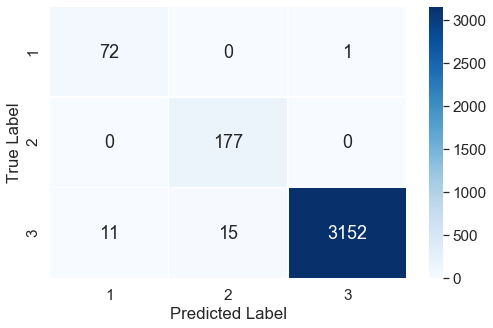

In [57]:
print(best_params)
best_classifier = DecisionTree(train_data, test_data, dataset.cost_data, impurity_measure=best_params[1], prune_length=best_params[2], use_cost=best_params[3], cost_weight=best_params[5], cost_measure=best_params[4])
matrix = best_classifier.evaluate_model()
plot_matrix(matrix)

The visaulization of the best classifier is given as follows

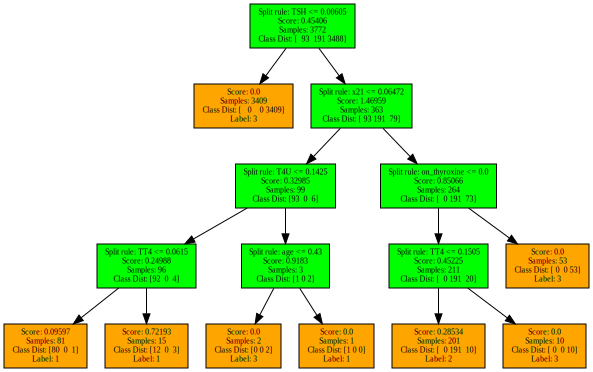

In [58]:
plot_tree(best_classifier)

Finally the test set is evaluated to find the accuracy values. The results are as follows:

In [73]:
acc_values = evaluate_matrix(matrix)
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))

Overall Accuracy: 0.9921236872812136
Class 1 Accuracy: 0.9863013698630136
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.9918187539332913


The same analysis is performed for the training set. The dconfusion matrix is as follows:

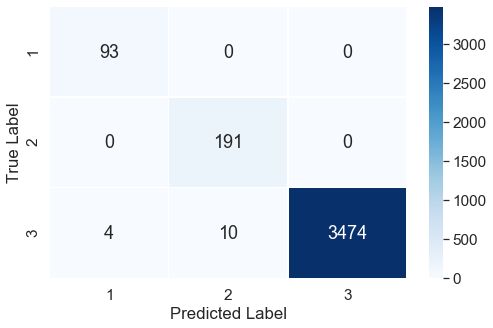

In [60]:
def evaluate_train_set(train_set, classifier):
    confusion_matrix = np.zeros((3,3), dtype=int)
    for sample_idx in range(train_set.shape[0]):
        sample = train_set[sample_idx,:]
        label = classifier.test_sample(sample)
        confusion_matrix[int(sample[-1]) - 1, label - 1] += 1
    return confusion_matrix
train_matrix = evaluate_train_set(train_data, best_classifier)
plot_matrix(train_matrix)

For this analysis the class based accuracies are as follows:

In [74]:
acc_values = evaluate_matrix(train_matrix)
print("Overall Accuracy: {}".format(acc_values[0]))
print("Class 1 Accuracy: {}".format(acc_values[1][0]))
print("Class 2 Accuracy: {}".format(acc_values[1][1]))
print("Class 3 Accuracy: {}".format(acc_values[1][2]))

Overall Accuracy: 0.996288441145281
Class 1 Accuracy: 1.0
Class 2 Accuracy: 1.0
Class 3 Accuracy: 0.9959862385321101


## Average Prediction Cost
As the fnal part of the analysis, the average prediction cost is calculated. This cost is computed by traversing the tree for every prediction. The implementation of this test is given as follows:

In [72]:
def get_prediction_cost(data_sample, classifier, dataset):
    node = classifier.root
    used_features = []
    features = list(dataset.cost_data.keys())
    total_cost = 0
    while node.left_child != None or node.right_child != None:
        cost = 0
        if node.feature_idx not in used_features:
            if node.feature_idx == 20:
                cost = 1.0
                if 19 not in used_features:
                    cost += dataset.cost_data[features[19]]
                    used_features.append(19)
                if 18 not in used_features:
                    cost += dataset.cost_data[features[18]]
                    used_features.append(18)
            else:
                cost = dataset.cost_data[features[node.feature_idx]]
                used_features.append(node.feature_idx)
        total_cost += cost
        if data_sample[node.feature_idx] <= node.threshold:
            node = node.left_child
        else:
            node = node.right_child
    return total_cost

def evaluate_avg_cost(test_samples):
    costs = []
    for sample_idx in range(test_samples.shape[0]):
        costs.append(get_prediction_cost(test_samples[sample_idx, :], best_classifier, dataset))
    return np.sum(np.array(costs)) / test_samples.shape[0]
print("Average prediction cost for test set: {}".format(round(evaluate_avg_cost(test_data), 4)))

Average prediction cost for test set: 25.5901
